In [21]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from models import make_model
import porepy as pp

# Grid refinement

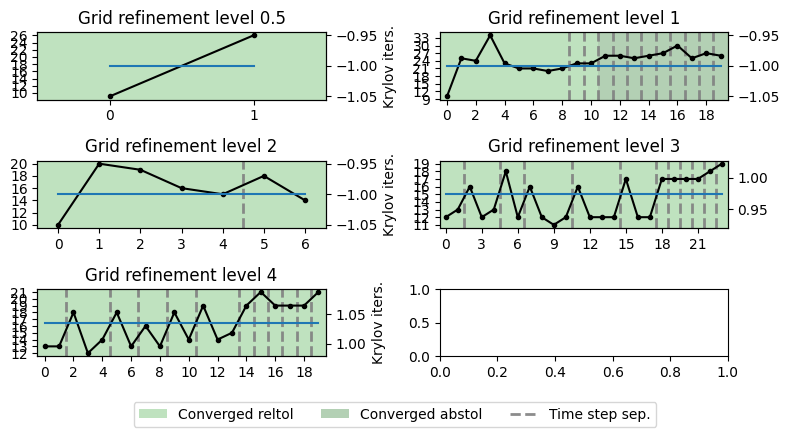

In [22]:
grid_refinement = [0.5, 1, 2, 3, 4]
geo = 3
ph = 1
bb = 2
fr = 1
sol = 2

data = {}
names = {}
for i, g in enumerate(grid_refinement):
    data[i] = load_data(f"../stats/stats_geo{geo}x{g}_sol{sol}_ph{ph}_bb{bb}_fr{fr}.json")
    names[i] = f"Grid refinement level {g}"


shape = [3, 2]
figsize = (8, 4)


def render_element(entry: list[TimeStepStats]):
    color_converged_reason(entry)
    # color_sticking_sliding_open(entry)

    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    set_integer_ticks("vertical")
    plt.plot(get_gmres_iterations(entry), marker=".", color="black")

    coulomb_mismatch = [ls.coulomb_mismatch for ts in entry for ls in ts.linear_solves]
    sticking_ut = [ls.sticking_u_mismatch for ts in entry for ls in ts.linear_solves]
    lambdan_max = [ls.lambdan_max for ts in entry for ls in ts.linear_solves]
    lambdan_max[0] = 0
    lambdat_max = [ls.lambdat_max for ts in entry for ls in ts.linear_solves]
    ujumpn_max = [ls.un_max for ts in entry for ls in ts.linear_solves]
    ujumpt_max = [ls.ut_max for ts in entry for ls in ts.linear_solves]
    error_rotation = [ls.error_matrix_contribution for ts in entry for ls in ts.linear_solves]

    plt.gca().twinx()
    # plt.yscale('log')
    # plt.plot(coulomb_mismatch, label='Coulomb mismatch')  # interesting
    # plt.plot(sticking_ut, label=r"Sticking $u_\tau$ mismatch")  # interesting
    # plt.plot(lambdan_max, label=r'$\lambda_n$ max')
    # plt.plot(lambdat_max, label=r'$\lambda_\tau$ max')
    # plt.plot(ujumpn_max, label=r"$u_n$ max")
    # plt.plot(ujumpt_max, label=r'$u_\tau$ max')
    plt.plot(error_rotation, label="Error matrix contribution")  # interesting
    # plt.ylim(bottom=1e-6)


plot_grid(
    data, render_element, shape=shape, figsize=figsize, legend=True, ax_titles=names
)

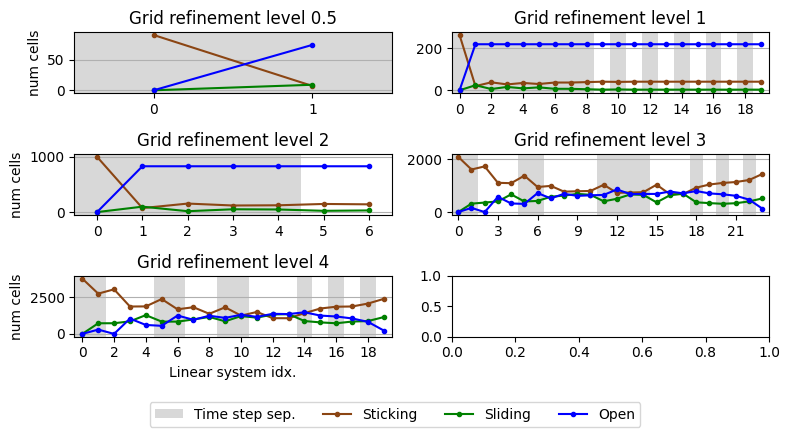

In [23]:
def render_element(i: int, entry: Sequence[TimeStepStats]):
    st, sl, op = get_num_sticking_sliding_open(entry)
    color_time_steps(entry, fill=True, grid=False, legend=True)
    plt.gca().grid(False)
    plt.gca().grid(True, which="major", axis="y")
    plt.plot(st, label="Sticking", marker=".", color=COLOR_STICKING)
    plt.plot(sl, label="Sliding", marker=".", color=COLOR_SLIDING)
    plt.plot(op, label="Open", marker=".", color=COLOR_OPEN)
    # plt.plot(tr, label="Transition", marker=".", color=COLOR_TRANSITION)


plot_grid(
    data,
    render_element,
    shape=shape,
    figsize=figsize,
    ylabel="num cells",
    ax_titles=names,
    #   ylabel="Fract. len., m"
)
# plt.savefig(save_path + 'fracture_length.pdf', bbox_inches='tight')

In [24]:
from collections import defaultdict
import pandas as pd

table = defaultdict(lambda: [])

NDIGITS = 2

for g in grid_refinement:
    stats_name = f'stats_geo{geo}x{g}_sol{sol}_ph{ph}_bb{bb}_fr{fr}.json'
    entry = load_data(f"../stats/{stats_name}")
    dofs_info = load_data(f"../stats/dofs_info_{stats_name}")
    total_dofs = (
        dofs_info["block 0"]
        + dofs_info["block 1"]
        + dofs_info["block 2"]
        + dofs_info["block 3"]
        + dofs_info["block 4"]
        + dofs_info["block 5"]
    )
    table['tmp'] = '-'
    table["Total DoFs"].append(int(total_dofs))
    table["GMRES iters."].append(int(np.mean(get_gmres_iterations(entry))))
    table['Newton iters.'].append(round(np.mean(get_newton_iterations(entry)), NDIGITS))

    converged_reason = get_petsc_converged_reason(entry)
    # table['\# lim iters.'].append(sum(np.array(get_petsc_converged_reason(entry)) < 0))

table = pd.DataFrame(table).T[1:]
table.rename(columns=table.iloc[0], inplace=True)
table = table[1:]
table.columns.name = 'Total DoFs'
table

Total DoFs,4810,24536,160476,514464,1185360
GMRES iters.,17,24,16,14,16
Newton iters.,2.0,1.67,3.5,2.0,1.67


In [25]:
print(table.to_latex(float_format=f'%.{NDIGITS}f'))

\begin{tabular}{llllll}
\toprule
Total DoFs & 4810 & 24536 & 160476 & 514464 & 1185360 \\
\midrule
GMRES iters. & 17 & 24 & 16 & 14 & 16 \\
Newton iters. & 2.00 & 1.67 & 3.50 & 2.00 & 1.67 \\
\bottomrule
\end{tabular}

